In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import celerite as celery
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP
np.random.seed(42)
%matplotlib inline

In [2]:
xo.__version__

'0.2.7.dev22+gf9141ef'

In [3]:
data_dir = '/Users/mbedell/python/pmodes/experiments/data/'
import utils

In [4]:
d = np.genfromtxt(data_dir+'sim_oneyear.csv', names=True, dtype=None, delimiter=',')
ts_all = np.copy(d['ts'])
rvs_all = np.copy(d['rvs'])
xs_all = np.copy(d['xs'])

In [5]:
time_per_night = 40. * 60. # seconds
nights_per_year = 60
integrated_kernel = False # for the > 1 minute exposures only
photon_noise_1min = 0.3 * np.sqrt(20.) # m/s error on 1-min integration - from 30 cm/s on 20-minutes

In [6]:
print(photon_noise_1min)

1.3416407864998738


#### observe for N consecutive 1-min integrations every night

In [7]:
start_ts_nightly = np.arange(30,30+nights_per_year) * 3600. * 24. # nightly on consecutive nights
start_ts_nightly += np.random.randint(-60, 60, nights_per_year)*60. # random perturbation of up to an hour before/after - can only be whole minutes to avoid interpolation
assert np.isin(start_ts_nightly, ts_all).all(), "Bad timestamp!"

In [8]:
exp_time = 1. * 60. # seconds per exposure
n_exp = int(time_per_night/exp_time)
t = np.ravel([np.arange(n_exp) * 60. + tt for tt in start_ts_nightly])
y = np.ravel([rvs_all[ts_all == tt] for tt in t])

In [9]:
# keep noiseless 1-min cadence RVs for later plotting convenience:
y_true_nightly = np.copy(y)
t_true_nightly = np.copy(t)

In [10]:
# add photon noise:
y += np.random.normal(0., photon_noise_1min, len(y))
yerr = np.zeros_like(t) + photon_noise_1min

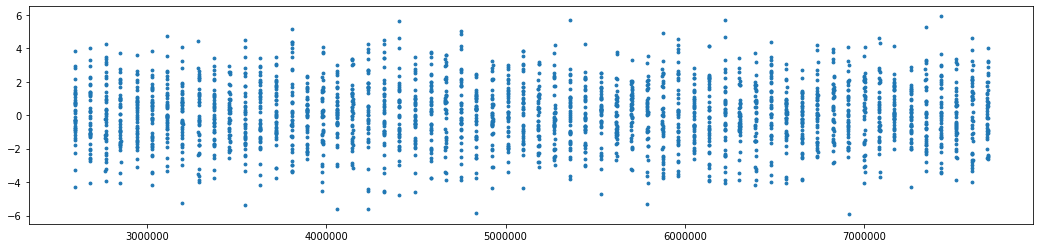

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
ax.scatter(t, y, s=8);

In [12]:
t_grid = utils.make_t_grid(start_ts_nightly, time_per_night)

In [13]:
y_pred, mu, sd = utils.gp_predict(t, y, yerr, t_grid, integrated=False)

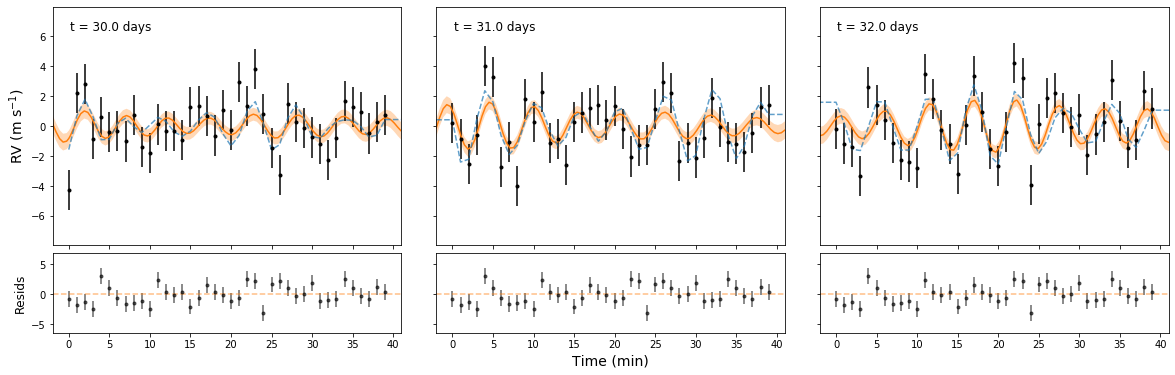

In [14]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts_nightly, t_grid, 
                        mu, sd, t_true_nightly, y_true_nightly, time_per_night=time_per_night)

In [15]:
print("net RMS = {0:.2f} m/s".format(np.sqrt(np.sum((y - y_pred)**2/len(y)))))

net RMS = 1.38 m/s


#### N consecutive observations per night, but random nights

In [16]:
start_ts_random = np.random.choice(np.arange(1,360), nights_per_year, replace=False) * 3600. * 24. # nightly for random nights (we're gonna ignore seasons)
start_ts_random += np.random.randint(-60, 60, nights_per_year)*60. # random perturbation of up to an hour before/after - can only be whole minutes to avoid interpolation
start_ts_random.sort()
assert np.isin(start_ts_random, ts_all).all(), "Bad timestamp!"

In [17]:
exp_time = 1. * 60. # seconds per exposure
n_exp = int(time_per_night/exp_time)
t = np.ravel([np.arange(n_exp) * 60. + tt for tt in start_ts_random])
y = np.ravel([rvs_all[ts_all == tt] for tt in t])

In [18]:
# keep noiseless 1-min cadence RVs for later plotting convenience:
y_true_random = np.copy(y)
t_true_random = np.copy(t)

In [19]:
# add photon noise:
y += np.random.normal(0., photon_noise_1min, len(y))
yerr = np.zeros_like(t) + photon_noise_1min

In [20]:
t_grid = utils.make_t_grid(start_ts_random, time_per_night)

In [21]:
y_pred, mu, sd = utils.gp_predict(t, y, yerr, t_grid, integrated=False)

In [22]:
# HACK:
if np.sum(np.isfinite(y_pred)) < len(y_pred):
    print("masking {0} NaN values from y_pred (length {1})".format(len(y_pred) - np.sum(np.isfinite(y_pred)),
                                                               len(y_pred)))
    y_pred[~np.isfinite(y_pred)] = 0.0

masking 1 NaN values from y_pred (length 2400)


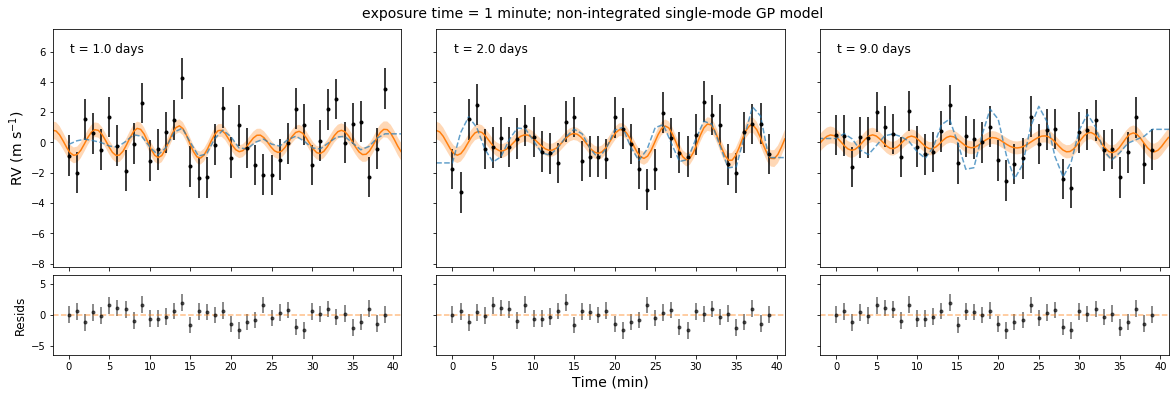

In [23]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts_random, t_grid, 
                        mu, sd, t_true_random, y_true_random, time_per_night=time_per_night)

fig.suptitle('exposure time = 1 minute; non-integrated single-mode GP model', y=0.93, fontsize=14)
fig.savefig('randomnights_1min_nonintegrated.png');

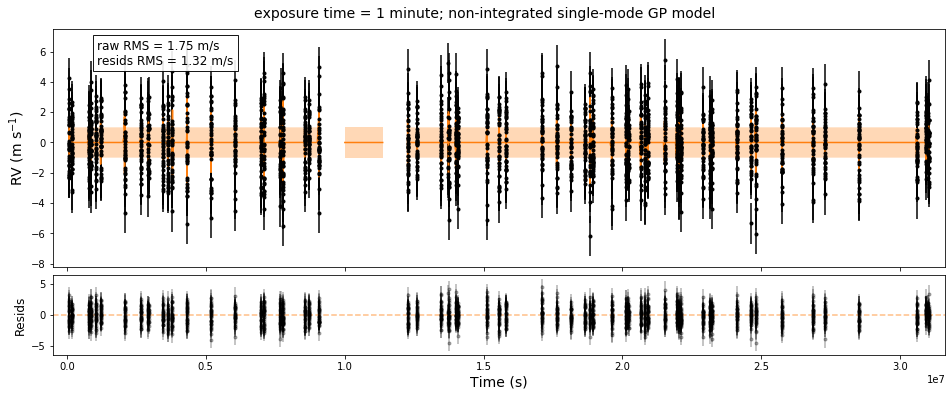

In [24]:
fig = utils.plot_year(t, y, yerr, y_pred, start_ts_random, t_grid, mu, sd)
fig.suptitle('exposure time = 1 minute; non-integrated single-mode GP model', y=0.93, fontsize=14)
fig.savefig('randomnights_1min_nonintegrated_full.png');

#### random nights, longer exposures

#### consecutive nights, 5-minute exposures

In [25]:
exp_time = 5. * 60. # seconds per exposure
n_exp = int(time_per_night/exp_time)

t = []
y = []

for st in start_ts_nightly:
    inds = (ts_all > st - 1800.) & (ts_all < st + time_per_night + 1800.)
    for n in range(n_exp):
        stt = st + n*exp_time # start time for this exposure, assumes no read time
        y.append(utils.simulate_exposure(ts_all[inds], rvs_all[inds], stt, exp_time))
        t.append(stt + exp_time/2.)
        
t = np.ravel(t)
y = np.ravel(y)

In [26]:
# add photon noise:
rv_noise_amp = photon_noise_1min / np.sqrt(exp_time/60.)
y += np.random.normal(0., rv_noise_amp, len(y)) # photon noise - 1 m/s for 1-minute
yerr = np.zeros_like(t) + rv_noise_amp

print("error: {0:.2f} m/s".format(yerr[0]))

error: 0.60 m/s


In [27]:
t_grid = utils.make_t_grid(start_ts_nightly, time_per_night)

In [28]:
y_pred, mu, sd = utils.gp_predict(t, y, yerr, t_grid, integrated=integrated_kernel, exp_time=exp_time)

In [29]:
# HACK:
if np.sum(np.isfinite(y_pred)) < len(y_pred):
    print("masking {0} NaN values from y_pred (length {1})".format(len(y_pred) - np.sum(np.isfinite(y_pred)),
                                                               len(y_pred)))
    y_pred[~np.isfinite(y_pred)] = 0.0

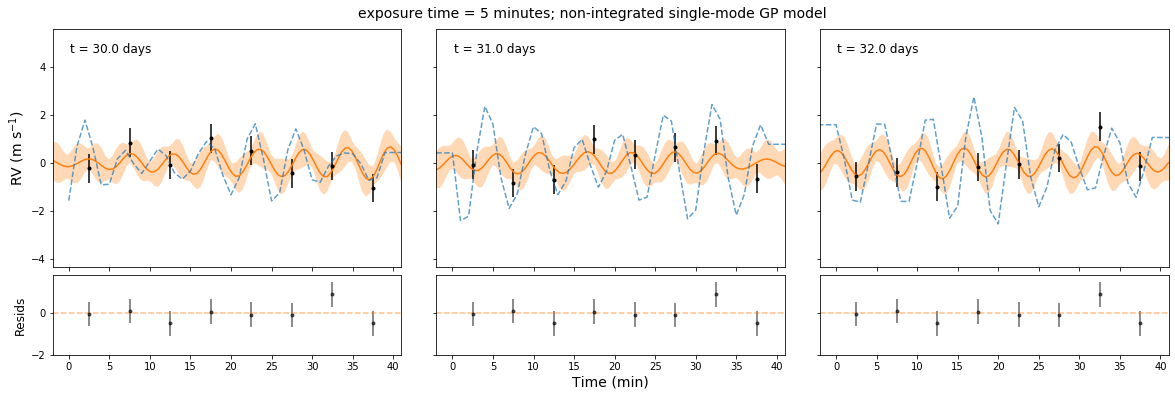

In [30]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts_nightly, t_grid, 
                        mu, sd, t_true_nightly, y_true_nightly, time_per_night=time_per_night)
if integrated_kernel:
    fig.suptitle('exposure time = {0:.0f} minutes; integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('allnights_{0:.0f}min_integrated.png'.format(exp_time/60.));
else:
    fig.suptitle('exposure time = {0:.0f} minutes; non-integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('allnights_{0:.0f}min_nonintegrated.png'.format(exp_time/60.));

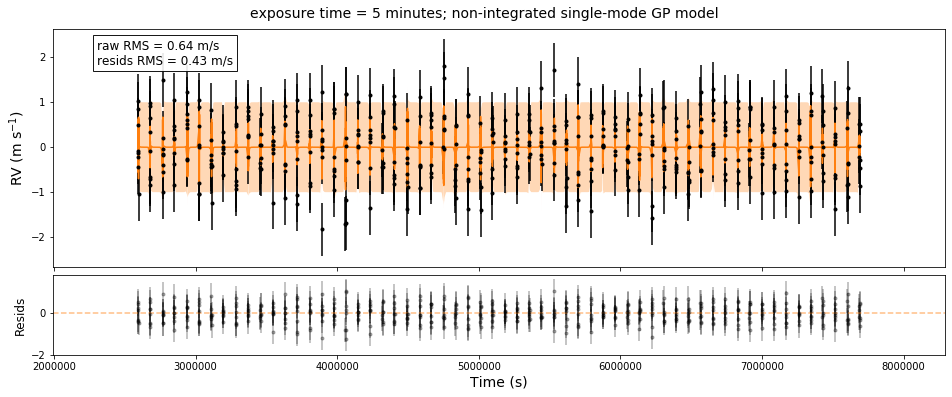

In [31]:
fig = utils.plot_year(t, y, yerr, y_pred, start_ts_nightly, t_grid, mu, sd)
if integrated_kernel:
    fig.suptitle('exposure time = {0:.0f} minutes; integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('allnights_{0:.0f}min_integrated_full.png'.format(exp_time/60.));
else:
    fig.suptitle('exposure time = {0:.0f} minutes; non-integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('allnights_{0:.0f}min_nonintegrated_full.png'.format(exp_time/60.));

In [32]:
print('RMS = {0:.2f} m/s'.format(np.sqrt(np.sum((y - y_pred)**2/len(y)))))

RMS = 0.43 m/s


#### consecutive nights, 20-minute exposures

In [33]:
exp_time = 20. * 60. # seconds per exposure
n_exp = int(time_per_night/exp_time)

t = []
y = []

for st in start_ts_nightly:
    inds = (ts_all > st - 1800.) & (ts_all < st + time_per_night + 1800.)
    for n in range(n_exp):
        stt = st + n*exp_time # start time for this exposure, assumes no read time
        y.append(utils.simulate_exposure(ts_all[inds], rvs_all[inds], stt, exp_time))
        t.append(stt + exp_time/2.)
        
t = np.ravel(t)
y = np.ravel(y)

In [34]:
# add photon noise:
y_true = np.copy(y)
rv_noise_amp = photon_noise_1min / np.sqrt(exp_time/60.)
y += np.random.normal(0., rv_noise_amp, len(y)) # photon noise - 1 m/s for 1-minute
yerr = np.zeros_like(t) + rv_noise_amp

print("error: {0:.2f} m/s".format(yerr[0]))

error: 0.30 m/s


In [35]:
t_grid = utils.make_t_grid(start_ts_nightly, time_per_night)

In [36]:
y_pred, mu, sd = utils.gp_predict(t, y, yerr, t_grid, integrated=integrated_kernel, exp_time=exp_time)

In [37]:
# HACK:
if np.sum(np.isfinite(y_pred)) < len(y_pred):
    print("masking {0} NaN values from y_pred (length {1})".format(len(y_pred) - np.sum(np.isfinite(y_pred)),
                                                               len(y_pred)))
    y_pred[~np.isfinite(y_pred)] = 0.0

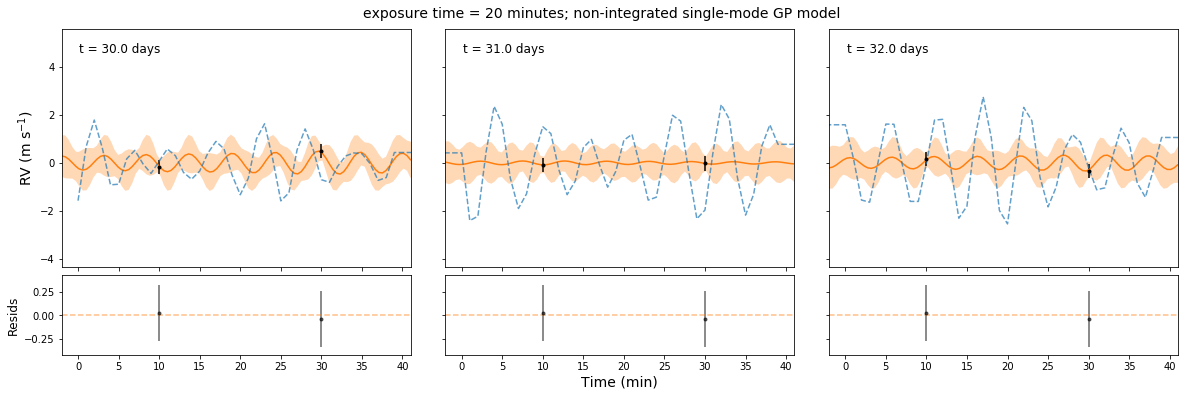

In [38]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts_nightly, t_grid, 
                        mu, sd, t_true_nightly, y_true_nightly, time_per_night=time_per_night)
if integrated_kernel:
    fig.suptitle('exposure time = {0:.0f} minutes; integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('allnights_{0:.0f}min_integrated.png'.format(exp_time/60.));
else:
    fig.suptitle('exposure time = {0:.0f} minutes; non-integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('allnights_{0:.0f}min_nonintegrated.png'.format(exp_time/60.));

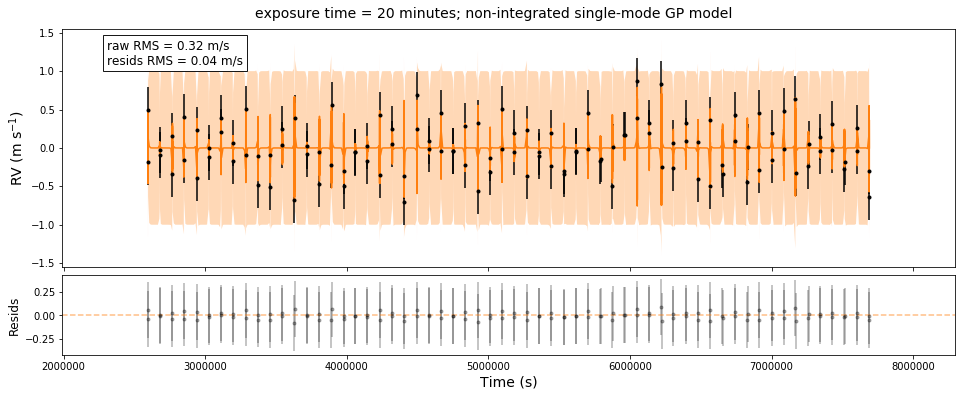

In [39]:
fig = utils.plot_year(t, y, yerr, y_pred, start_ts_nightly, t_grid, mu, sd)
if integrated_kernel:
    fig.suptitle('exposure time = {0:.0f} minutes; integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('allnights_{0:.0f}min_integrated_full.png'.format(exp_time/60.));
else:
    fig.suptitle('exposure time = {0:.0f} minutes; non-integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('allnights_{0:.0f}min_nonintegrated_full.png'.format(exp_time/60.));

In [40]:
print('RMS = {0:.2f} m/s'.format(np.sqrt(np.sum((y - y_pred)**2/len(y)))))

RMS = 0.04 m/s
